# <center>Assessment CLO-3: Tugas Pemrograman Learning</center>

<b>Topik</b>
Klasifikasi pada Dataset 8: Sirtuin6 Small Molucules menggunakan Decision Tree dan KNN

<b>Kelompok 1: </b>

Anggota:
1. Valentino Hartanto - 1301223020
2. Gede Bagus Krishnanditya Merta - 1301223088 
3. Raka Aditya Waluya - 1301220192

#### Pendahuluan
Data ini mencakup 100 molekul dengan 6 descriptors yang paling relevan untuk menentukan kandidat inhibitors protein target, Sirtuin 6. Molekul molekul ini dikelompokkan berdasarkan low BFE dan high BFE

Kami tidak melakukan banyak preprocessing data, dikarenakan terlihat bahwa data sudah cukup bagus. Namun terdapat beberapa issue yang perlu diperhatikan dalam data seperti adanya unique value dalam 2 feature data (SC-6 dan maxwHBa) dan adanya banyak nilai 0 pada feature SHBd dan minHaaCH, banyaknya nilai 0 ini bisa diakibatkan oleh outlier. Oleh karenanya kami melakukan visualisasi boxplot untuk melihat outlier tersebut, setelah itu kami menangani outlier dengan menggunakan metode IQR

kami bereksperimen terhadap data training dan data testing yang ada. Kami membuat dua pasang data training dan data testing, salah satu data training dan testing tersebut kami lakukan scaling data, dan yang satunya tidak. Hal ini kami lakukan untuk melihat apakah data scaling pada dataset ini akan memberikan perbedaan yang signifikan pada model KNN atau tidak. 

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, learning_curve
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import ttest_rel

In [3]:
df = pd.read_csv('SIRTUIN6.csv')
df.head()

,SC-5,SP-6,SHBd,minHaaCH,maxwHBa,FMF,Class
0,0.540936,7.64192,0.162171,0.445270,2.20557,0.467742,High_BFE
1,0.815332,6.59011,0.000000,0.497445,2.00314,0.415385,High_BFE
2,0.734399,6.85522,0.000000,0.507748,1.88590,0.400000,High_BFE
3,0.624557,7.00949,0.450300,0.483648,2.02757,0.500000,High_BFE
4,0.460290,4.92643,0.448998,0.482293,2.06438,0.536585,High_BFE


In [4]:
df.describe()

,SC-5,SP-6,SHBd,minHaaCH,maxwHBa,FMF
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.420488,4.429250,0.356504,0.443628,1.919511,0.376232
std,0.195124,1.403348,0.339313,0.138964,0.522992,0.072255
min,0.083333,2.091810,0.000000,0.000000,0.000000,0.153846
25%,0.282118,3.345093,0.000000,0.429809,1.839850,0.326531
50%,0.393350,4.107115,0.373387,0.467655,2.020210,0.376024
75%,0.532954,5.302952,0.482501,0.505934,2.161543,0.423240
max,0.918546,7.641920,1.465000,0.720723,3.778650,0.536585


In [4]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

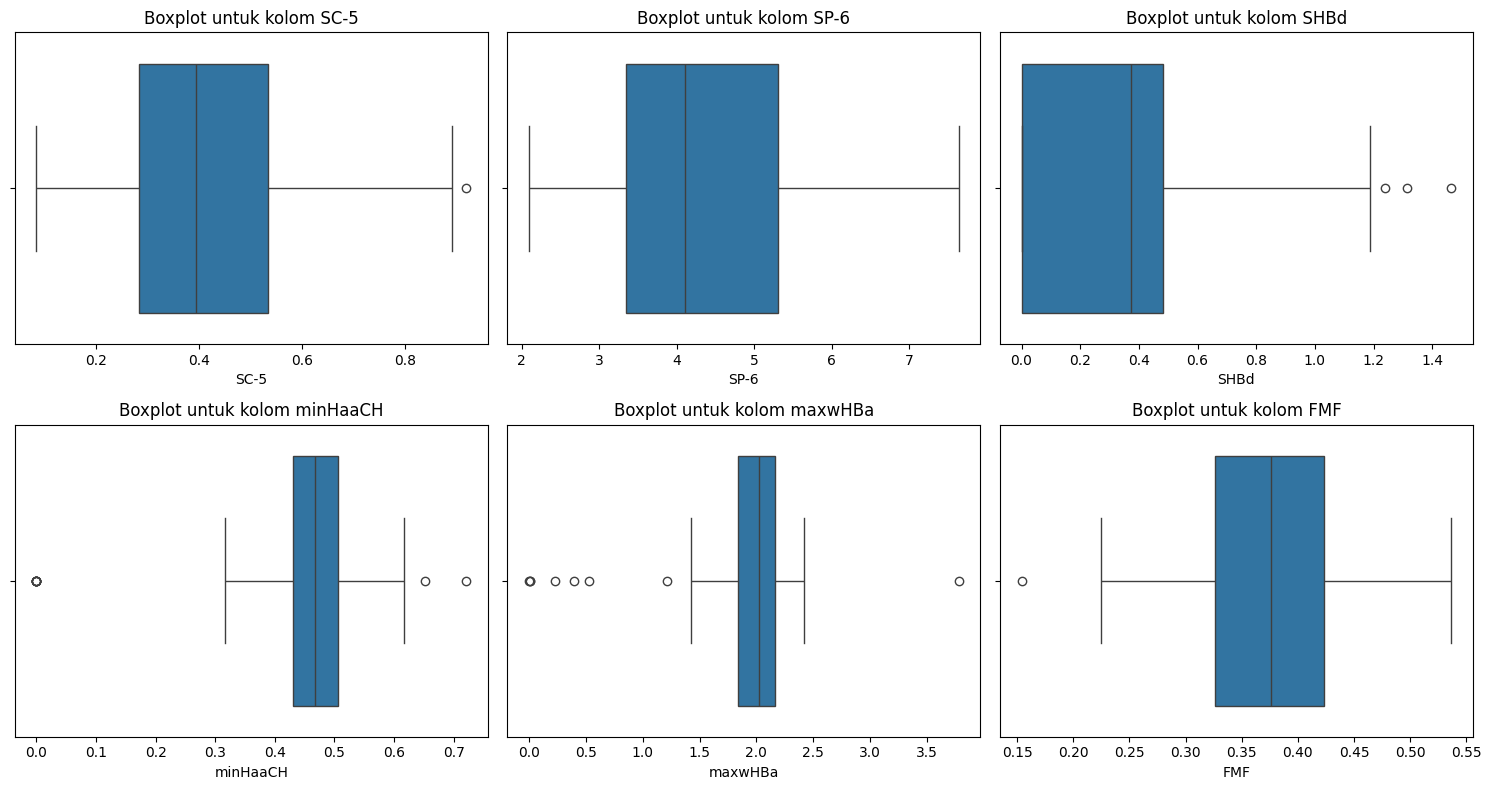

In [5]:
# mengecek outliers
%matplotlib inline
num_cols = len(df.select_dtypes(include=['int', 'float']).columns)
plt.figure(figsize=(15,8))
rows = (num_cols + 2)//3
for i, col in enumerate(df.select_dtypes(include=['int', 'float']).columns):
    plt.subplot(rows, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot untuk kolom {col}')
plt.tight_layout()
plt.show()

In [6]:
# menangani outlier menggunakan metode IQR
def handle_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1 
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = data[column].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))
    return data

for col in df.select_dtypes(include=['int', 'float']).columns:
    df = handle_outliers(df, col)

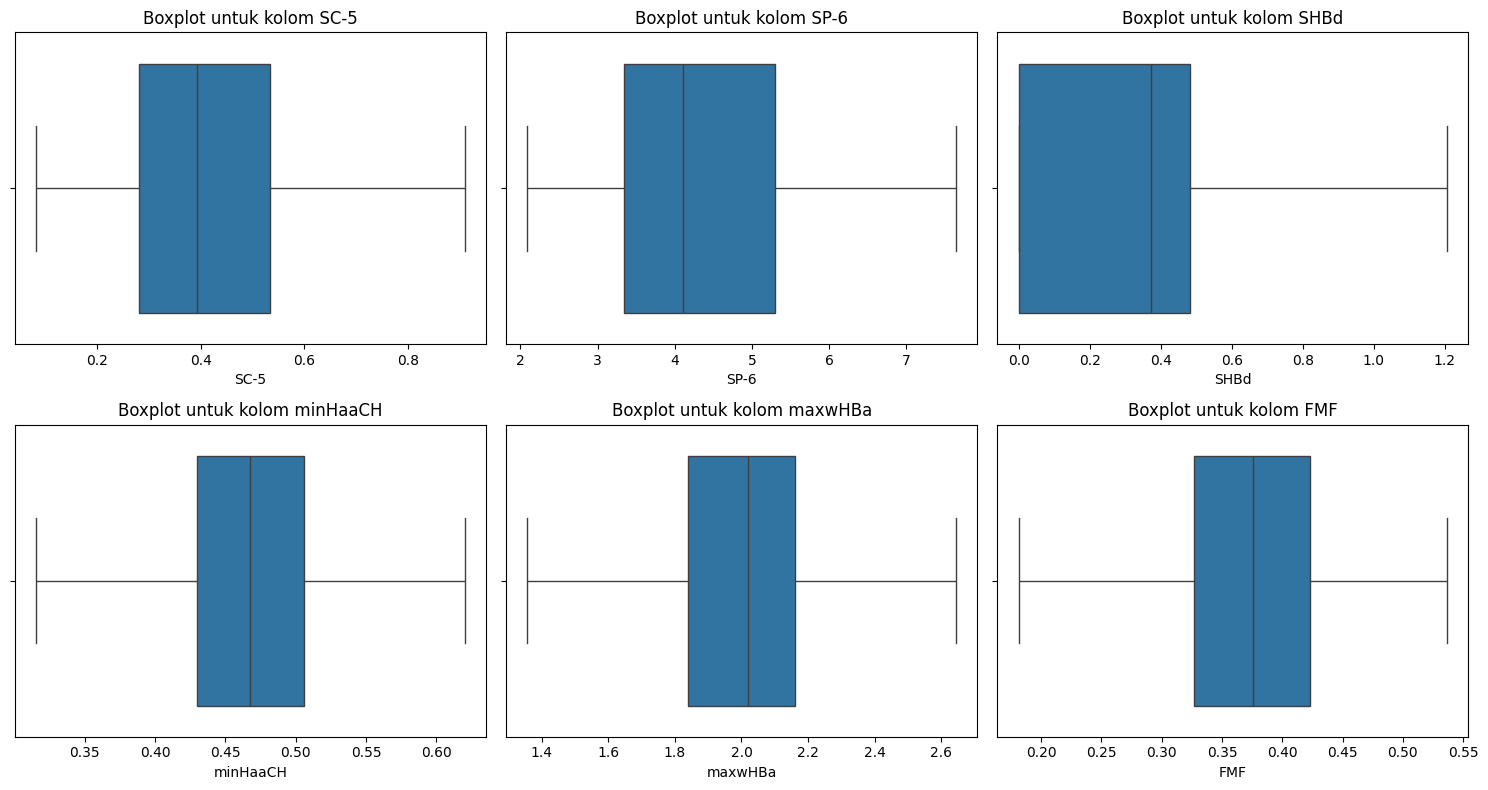

In [7]:
# mengecek outliers
num_cols = len(df.select_dtypes(include=['int', 'float']).columns)
plt.figure(figsize=(15,8))
rows = (num_cols + 2)//3
for i, col in enumerate(df.select_dtypes(include=['int', 'float']).columns):
    plt.subplot(rows, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot untuk kolom {col}')
plt.tight_layout()
plt.show()

In [8]:
X = df.drop('Class', axis=1)
y = df['Class']

indices = np.arange(X.shape[0])
scaler = StandardScaler()

# membagi train test data dan melakukan scaling (80:20)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=42
)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_scaled = scaler.transform(X)

# membagi train test data tanpa melakukan scaling (80:20)
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Metode yang Digunakan
Kami bereksperimen untuk menggunakan 2 metode (Decision Tree, dan KNN). Untuk parameter kedua model, kami menggunakan GridSeachCV untuk tuning hyperparameter terbaik. 

Parameter yang kami coba untuk Decision Tree antara lain: max_depth, min_samples_split, min_sample_leaf, max_leaf_nodes, dan max_features. 

Parameter yang kami coba untuk KNN antara lain: n_neighbors, weights, metric, dan leaf_size.

### Decision Tree Classifier

In [9]:
normal_tree = DecisionTreeClassifier(random_state=42)
normal_tree.fit(X1_train, y1_train)

DecisionTreeClassifier(random_state=42)

In [10]:
normal_tree_y_pred = normal_tree.predict(X1_test)
print(classification_report(y1_test, normal_tree_y_pred))

              precision    recall  f1-score   support

    High_BFE       0.80      1.00      0.89        12
     Low_BFE       1.00      0.62      0.77         8

    accuracy                           0.85        20
   macro avg       0.90      0.81      0.83        20
weighted avg       0.88      0.85      0.84        20



In [11]:
print(f"Training Accuracy: {accuracy_score(y1_train, normal_tree.predict(X1_train)):.2f}")
print(f"Test Accuracy: {accuracy_score(y1_test, normal_tree.predict(X1_test)):.2f}")

Training Accuracy: 1.00
Test Accuracy: 0.85


In [12]:
print(confusion_matrix(y1_test, normal_tree_y_pred))

[[12  0]
 [ 3  5]]


In [13]:
score_normal_tree = cross_val_score(normal_tree, X1_train, y1_train, cv=5)
print(f'Akurasi rata-rata model dengan cv=5: {score_normal_tree.mean()}')
print(score_normal_tree)

Akurasi rata-rata model dengan cv=5: 0.8
[0.8125 0.9375 0.6875 0.5625 1.    ]


Berdasarkan hasil akurasi train dan test data pada model decision tree tersebut, dapat disimpulkan model tersebut mengalami overfitting. hal ini dapat dikarenakan terdapat 2 feature yang memiliki unique value. 

Selanjutnya kami mencoba melakukan preprune pada model tree tersebut untuk melihat apakah overfitting dapat berkurang atau tidak

In [14]:
normal_tree.get_params() # melihat parameter yang tersedia dari decision tree 

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [15]:
# Melakukan Pre Prune Tree
param_dist = {
    'max_depth': [2, 3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_leaf_nodes': [5, 10, 15, 20, 25, 30],
    'max_features': [1, 2, 3, 4, 5, 6],
}

GridSearch_tree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=GridSearch_tree, param_grid=param_dist, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X1_train, y1_train)

# Hyperparameter terbaik
best_params = grid_search.best_params_
print(f"Hyperparameter terbaik: {best_params}")


Fitting 5 folds for each of 6300 candidates, totalling 31500 fits
Hyperparameter terbaik: {'max_depth': 3, 'max_features': 6, 'max_leaf_nodes': 10, 'min_samples_leaf': 3, 'min_samples_split': 2}


In [16]:
# pre prune tree
prePrune_tree = DecisionTreeClassifier(max_depth=3, max_features=6, max_leaf_nodes=10, min_samples_leaf=3, min_samples_split=2, random_state=42)
prePrune_tree = prePrune_tree.fit(X1_train, y1_train)

In [17]:
prePrune_tree_y_pred = prePrune_tree.predict(X1_test)
print(classification_report(y1_test, prePrune_tree_y_pred))

              precision    recall  f1-score   support

    High_BFE       0.75      1.00      0.86        12
     Low_BFE       1.00      0.50      0.67         8

    accuracy                           0.80        20
   macro avg       0.88      0.75      0.76        20
weighted avg       0.85      0.80      0.78        20



In [18]:
print(f"Training Accuracy: {accuracy_score(y1_train, prePrune_tree.predict(X1_train)):.2f}")
print(f"Test Accuracy: {accuracy_score(y1_test, prePrune_tree.predict(X1_test)):.2f}")

Training Accuracy: 0.91
Test Accuracy: 0.80


In [19]:
print(confusion_matrix(y1_test, prePrune_tree_y_pred))

[[12  0]
 [ 4  4]]


In [20]:
score_prePrune_tree = cross_val_score(prePrune_tree, X1_train, y1_train, cv=5)
print(f'Akurasi rata-rata model dengan cv=5: {score_prePrune_tree.mean()}')
print(score_prePrune_tree)

Akurasi rata-rata model dengan cv=5: 0.875
[0.8125 1.     0.8125 0.75   1.    ]


Meskipun sudah melakukan pre prune pada model, perbedaan akurasi pada data train, dan data test masih signifikan. Perbedaan ini menunjukkan bahwa model masih terlalu baik dalam mempelajari pola-pola yang ada pada data training, tetapi tidak mampu menggeneralisasi dengan baik pada data baru.

In [21]:
feature_names = X.columns
feature_importance = pd.DataFrame(normal_tree.feature_importances_, index=feature_names).sort_values(by=0, ascending=False)
feature_importance

,0
SP-6,0.497295
FMF,0.220473
minHaaCH,0.129159
SC-5,0.107961
maxwHBa,0.045113
SHBd,0.000000


<Axes: >

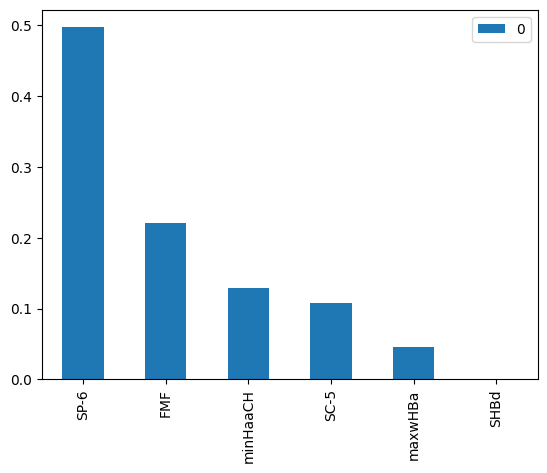

In [22]:
feature_importance.plot(kind='bar')

Feature SP-6 memiliki nilai unik yang berkemungkinan besar mempengaruhi model decision tree secara signifikan terhadap overfitting. Feature SP-6 juga memiliki importance yang tinggi, hal ini dapat diartikan bahwa model akan terlalu bergantung pada fitur ini. Feature dengan nilai unik bisa jadi mengandung noise atau variasi yang tidak relevan, sehingga membuat model mempelajari noise tersebut daripada pola yang sebenarnya.

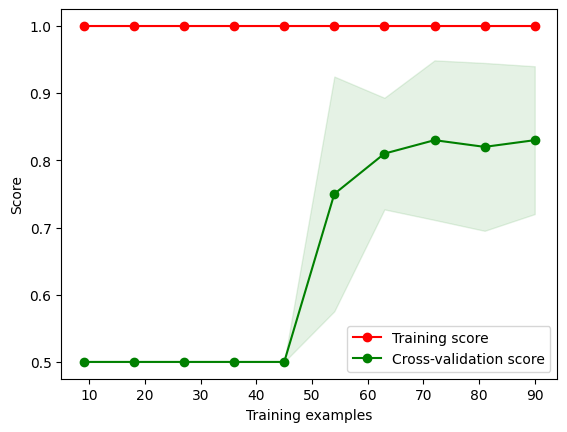

In [23]:
# Learning Curve normal tree
train_sizes, train_scores, test_scores = learning_curve(
    normal_tree, X, y, cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

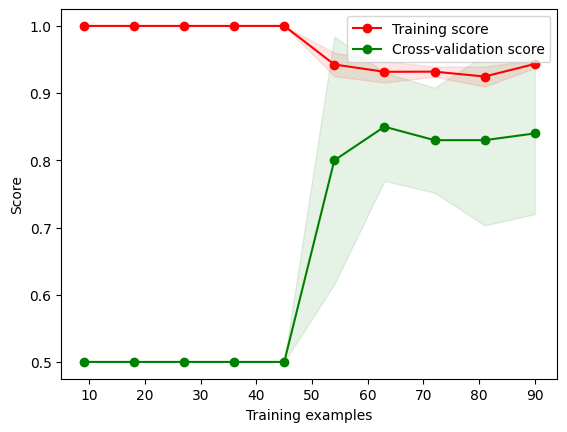

In [24]:
# Learning Curve Pre prune tree
train_sizes, train_scores, test_scores = learning_curve(
    prePrune_tree, X, y, cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

Plot tersebut menunjukkan kinerja model pada train data dan validation data berdasarkan jumlah cross validation. Perbedaan besar antara score pada train data dan skor validation data yang rendah mengindikasikan bahwa model overfit pada train data.

### KNN dengan Scaled Data

In [25]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [26]:
knn_y_pred = knn.predict(X_test)
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

    High_BFE       0.85      0.92      0.88        12
     Low_BFE       0.86      0.75      0.80         8

    accuracy                           0.85        20
   macro avg       0.85      0.83      0.84        20
weighted avg       0.85      0.85      0.85        20



In [27]:
print(f"Training Accuracy: {accuracy_score(y_train, knn.predict(X_train)):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, knn.predict(X_test)):.2f}")

Training Accuracy: 0.82
Test Accuracy: 0.85


In [28]:
print(confusion_matrix(y1_test, knn_y_pred))

[[11  1]
 [ 2  6]]


In [29]:
scores_pre_prune = cross_val_score(knn, X_train, y_train, cv=5)
print(f'Akurasi rata-rata model menggunakan cv=5: {scores_pre_prune.mean()}')
print(scores_pre_prune)

Akurasi rata-rata model menggunakan cv=5: 0.7375
[0.75   0.875  0.8125 0.5    0.75  ]


Berdasarkan data tersebut Training Accuracy 0.82, Test Accuracy 0.85, dan mean cross val accuracy 0.7375, menunjukkan bahwa model sudah cukup baik kemampuannya. Namun nilai dari mean cross val accuracy yang rendah dapat menunjukkan potensi overfitting, hal ini juga mengindikasikan bahwa model masih kesulitan dalam memprediksi data yang bervariasi.

Untuk mengatasi hal tersebut, kami mencoba untuk melakukan tuning parameter pada model tersebut

In [30]:
knn.get_params() # melihat parameter yang tersedia dari KNN

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [31]:
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'leaf_size': [5, 10, 20, 30, 40, 50]
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

# Hyperparameter terbaik
best_params = grid_search.best_params_
print(f"Hyperparameter terbaik: {best_params}")


Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Hyperparameter terbaik: {'leaf_size': 5, 'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}


In [32]:
# KNN dengan tuning parameter
KNNtuned = KNeighborsClassifier(leaf_size=5,metric='euclidean',n_neighbors=9,weights='uniform')
KNNtuned.fit(X_train, y_train)

KNeighborsClassifier(leaf_size=5, metric='euclidean', n_neighbors=9)

In [33]:
KNNtuned_y_pred = KNNtuned.predict(X_test)
print(classification_report(y_test, KNNtuned_y_pred))

              precision    recall  f1-score   support

    High_BFE       0.85      0.92      0.88        12
     Low_BFE       0.86      0.75      0.80         8

    accuracy                           0.85        20
   macro avg       0.85      0.83      0.84        20
weighted avg       0.85      0.85      0.85        20



In [34]:
print(f"Training Accuracy: {accuracy_score(y_train, KNNtuned.predict(X_train)):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, KNNtuned.predict(X_test)):.2f}")

Training Accuracy: 0.82
Test Accuracy: 0.85


In [35]:
print(confusion_matrix(y1_test, KNNtuned_y_pred))

[[11  1]
 [ 2  6]]


In [36]:
scores_pre_prune = cross_val_score(KNNtuned, X_train, y_train, cv=5)
print(f'Akurasi rata-rata model menggunakan cv=5: {scores_pre_prune.mean()}')
print(scores_pre_prune)

Akurasi rata-rata model menggunakan cv=5: 0.8125
[0.8125 0.9375 0.75   0.6875 0.875 ]


Setelah melakukan tuning parameter, terlihat bahwa akurasi model pada data test masih sama, namun akurasi rata rata pada cross val sudah jauh lebih baik, perbedaan yang cukup kecil pada nilai rata rata cross val dapat menandakan bahwa model sudah cukup baik dalam generalisasi data.

### KNN tanpa Scaled Data

Setelah membuat model dengan data yang sudah di scale, kami mencoba untuk melatih model dengan data yang tidak di scale dan membandingkan hasilnya.

In [37]:
knn1 = KNeighborsClassifier()
knn1.fit(X1_train, y1_train)

KNeighborsClassifier()

In [38]:
knn1_y_pred = knn1.predict(X1_test)
print(classification_report(y1_test, knn1_y_pred))

              precision    recall  f1-score   support

    High_BFE       0.80      1.00      0.89        12
     Low_BFE       1.00      0.62      0.77         8

    accuracy                           0.85        20
   macro avg       0.90      0.81      0.83        20
weighted avg       0.88      0.85      0.84        20



In [39]:
print(f"Training Accuracy: {accuracy_score(y1_train, knn1.predict(X1_train)):.2f}")
print(f"Test Accuracy: {accuracy_score(y1_test, knn1.predict(X1_test)):.2f}")

Training Accuracy: 0.82
Test Accuracy: 0.85


In [40]:
print(confusion_matrix(y1_test, knn1_y_pred))

[[12  0]
 [ 3  5]]


In [41]:
scores_pre_prune = cross_val_score(knn1, X1_train, y1_train, cv=5)
print(f'Akurasi rata-rata model menggunakan cv=5: {scores_pre_prune.mean()}')
print(scores_pre_prune)

Akurasi rata-rata model menggunakan cv=5: 0.7875
[0.75   0.875  0.75   0.75   0.8125]


Sama seperti sebelumnya, akurasi model sudah cukup baik. Namun nilai rata rata cross val score masih cukup rendah. Selanjutnya kami mencoba melakukan tuning parameter untuk memperbaiki score dari cross val tersebut.

In [42]:
param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'leaf_size': [5, 10, 20, 30, 40, 50]
}

grid_search = GridSearchCV(estimator=knn1, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X1_train, y1_train)

# Hyperparameter terbaik
best_params = grid_search.best_params_
print(f"Hyperparameter terbaik: {best_params}")


Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Hyperparameter terbaik: {'leaf_size': 5, 'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}


In [43]:
# KNN dengan tuning parameter
KNNtuned1 = KNeighborsClassifier(leaf_size=5,metric='manhattan',n_neighbors=3,weights='uniform')
KNNtuned1.fit(X1_train, y1_train)

KNeighborsClassifier(leaf_size=5, metric='manhattan', n_neighbors=3)

In [44]:
KNNtuned1_y_pred = KNNtuned1.predict(X1_test)
print(classification_report(y1_test, KNNtuned1_y_pred))

              precision    recall  f1-score   support

    High_BFE       0.80      1.00      0.89        12
     Low_BFE       1.00      0.62      0.77         8

    accuracy                           0.85        20
   macro avg       0.90      0.81      0.83        20
weighted avg       0.88      0.85      0.84        20



In [45]:
print(f"Training Accuracy: {accuracy_score(y1_train, KNNtuned1.predict(X1_train)):.2f}")
print(f"Test Accuracy: {accuracy_score(y1_test, KNNtuned1.predict(X1_test)):.2f}")

Training Accuracy: 0.86
Test Accuracy: 0.85


In [46]:
print(confusion_matrix(y1_test, KNNtuned1_y_pred))

[[12  0]
 [ 3  5]]


In [47]:
scores_pre_prune = cross_val_score(KNNtuned1, X1_train, y1_train, cv=5)
print(f'Akurasi rata-rata model menggunakan cv=5: {scores_pre_prune.mean()}')
print(scores_pre_prune)

Akurasi rata-rata model menggunakan cv=5: 0.825
[0.75   0.9375 0.8125 0.75   0.875 ]


Setelah melakukan tuning parameter terlihat bahwa model memperoleh score yang lebih baik, namun tidak signifikan. 

### Scaled Data vs Unscaled Data

In [48]:
# kami mencoba membandingkan beberapa metric untuk kedua model (dengan scaling data dan tanpa scaling data)
def evaluate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    precision = cross_val_score(model, X, y, cv=5, scoring='precision_macro')
    recall = cross_val_score(model, X, y, cv=5, scoring='recall_macro')
    f1 = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
    return scores, precision, recall, f1

# Evaluasi tanpa scaler
scores_no_scaler, precision_no_scaler, recall_no_scaler, f1_no_scaler = evaluate_model(KNNtuned, X_train, y_train)

# Evaluasi dengan scaler
scores_with_scaler, precision_with_scaler, recall_with_scaler, f1_with_scaler = evaluate_model(KNNtuned1, X1_train, y1_train)

t_stat, p_value = ttest_rel(scores_no_scaler, scores_with_scaler)

print(f'Accuracy without Scaler: {scores_no_scaler.mean():.2f} ± {scores_no_scaler.std():.2f}')
print(f'Precision without Scaler: {precision_no_scaler.mean():.2f} ± {precision_no_scaler.std():.2f}')
print(f'Recall without Scaler: {recall_no_scaler.mean():.2f} ± {recall_no_scaler.std():.2f}')
print(f'F1-score without Scaler: {f1_no_scaler.mean():.2f} ± {f1_no_scaler.std():.2f}')

print(f'\nAccuracy with Scaler: {scores_with_scaler.mean():.2f} ± {scores_with_scaler.std():.2f}')
print(f'Precision with Scaler: {precision_with_scaler.mean():.2f} ± {precision_with_scaler.std():.2f}')
print(f'Recall with Scaler: {recall_with_scaler.mean():.2f} ± {recall_with_scaler.std():.2f}')
print(f'F1-score with Scaler: {f1_with_scaler.mean():.2f} ± {f1_with_scaler.std():.2f}')

print(f'\nT-statistic: {t_stat:.2f}, P-value: {p_value:.2f}')

Accuracy without Scaler: 0.81 ± 0.09
Precision without Scaler: 0.84 ± 0.08
Recall without Scaler: 0.81 ± 0.09
F1-score without Scaler: 0.81 ± 0.09

Accuracy with Scaler: 0.82 ± 0.07
Precision with Scaler: 0.84 ± 0.07
Recall with Scaler: 0.83 ± 0.07
F1-score with Scaler: 0.82 ± 0.07

T-statistic: -0.53, P-value: 0.62


Berdasarkan hasil tersebut diketahui bahwa perbedaan kedua model tidak terlalu signifikan, selisih dalam nilai mean dan standar deviasi  relatif kecil antara kedua kondisi data (dengan scaling dan tanpa scaling). Hal ini diperkuat dengan hasil t-statistik yang mendekati nol dan p-value yang tinggi, menunjukkan bahwa tidak ada perbedaan signifikan antara kedua kondisi.

Namun dalam konteks stabilitas, data yang telah di-scale cenderung lebih stabil daripada data yang tidak di-scale. Hal ini karena scaling dapat membantu mengurangi variasi dalam data, yang dapat menyebabkan fluktuasi yang lebih besar dalam hasil model.

In [49]:
# Mengecek apakah X_scaled == X_train concat X_test
X_combined_scaled = np.empty_like(X_scaled)
X_combined_scaled[idx_train] = X_train
X_combined_scaled[idx_test] = X_test

print(np.array_equal(X_combined_scaled, X_scaled)) 

True


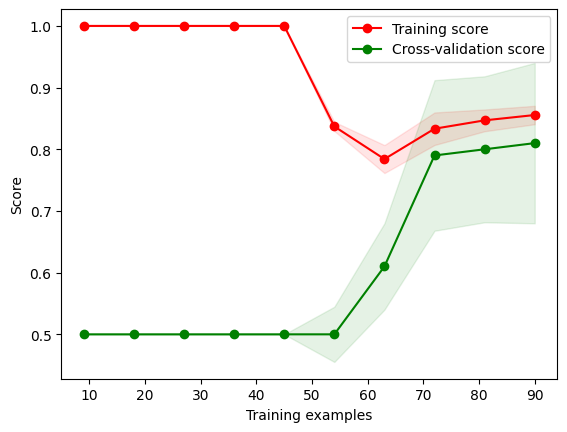

In [50]:
# Learning Curve KNN menggunakan data dengan scaling
train_sizes, train_scores, test_scores = learning_curve(
    KNNtuned, X_scaled, y, cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

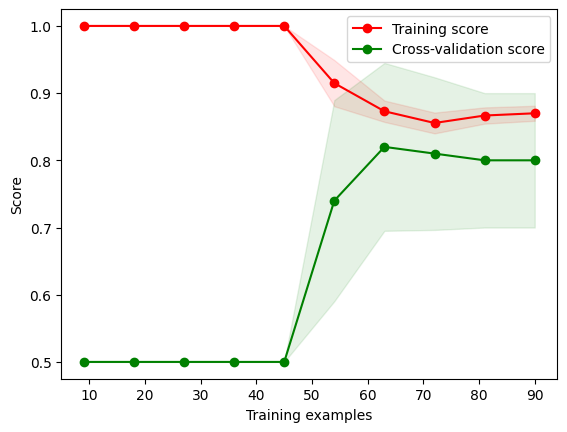

In [51]:
# Learning Curve KNN menggunakan data tanpa scaling
train_sizes, train_scores, test_scores = learning_curve(
    KNNtuned1, X, y, cv=10, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-validation score")

plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

### Penutup

<h3>Hasil dan Analisis</h3>

<b>Hasil :</b> 

<b>[ Decision Tree ]</b>

Setelah melakukan beberapa eksperimen pada parameter Decision Tree kami mendapatkan hasil sebagai berikut,

- Classification Report untuk Normal Tree (tanpa tuning parameter)

    <img src="./public/classification_report_normal_tree.png" width="350">

    Akurasi train data pada Normal Tree: 1.00

    Akurasi rata-rata model dengan cv=5: 0.8
    
- Classification Report untuk Prune Tree (dengan tuning parameter)

    <img src="./public/classification_report_prune_tree.png" width="350">

    Akurasi train data pada Prune Tree: 0.91

    Akurasi rata-rata model dengan cv=5: 0.875

- Learning Curve untuk Normal Tree (tanpa tuning parameter)

    <img src="./public/learning_curve_normal_tree.png" width="350">

- Learning Curve untuk Prune Tree (dengan tuning parameter)

    <img src="./public/learning_curve_prune_tree.png" width="350">


<b>[ KNN scaled data ]</b>

Setelah melakukan beberapa eksperimen pada parameter KNN kami mendapatkan hasil sebagai berikut,

- Classification Report untuk model KNN (tanpa tuning parameter)

    <img src="./public/classification_report_knn.png" width="350">

    Akurasi train data pada model KNN: 0.82

    Akurasi rata-rata model menggunakan cv=5: 0.7375

    
- Classification Report untuk Tuned KNN (dengan tuning parameter)

    <img src="./public/classification_report_tuned_knn.png" width="350">

    Akurasi train data pada Tuned KNN: 0.82

    Akurasi rata-rata model menggunakan cv=5: 0.8125

- Learning Curve untuk Tuned KNN (dengan tuning parameter)

    <img src="./public/learning_curve_tuned_knn_scaled_data.png" width="350">


<b>[ KNN unscaled data ]</b>

Setelah melakukan beberapa eksperimen pada parameter KNN kami mendapatkan hasil sebagai berikut,

- Classification Report untuk model KNN (tanpa tuning parameter)

    <img src="./public/classification_report_knn_unscaled_data.png" width="350">

    Akurasi train data pada model KNN: 0.82

    Akurasi rata-rata model menggunakan cv=5: 0.7875

    
- Classification Report untuk Tuned KNN (dengan tuning parameter)

    <img src="./public/classification_report_tuned_knn_unscaled_data.png" width="350">

    Akurasi train data pada Tuned KNN: 0.86

    Akurasi rata-rata model menggunakan cv=5: 0.825

- Learning Curve untuk Tuned KNN (dengan tuning parameter)

    <img src="./public/learning_curve_tuned_knn_unscaled_data.png" width="350">

<b>Analisis:</b>

<b>[ Decision Tree ]</b>

Decision Tree memberikan akurasi pada data test yang cukup baik (sekitar 0.8 - 0.85), namun model ini memberikan akurasi pada data train yang jauh berbeda dengan data test. Perbedaan yang sangat jauh ini mengindikasikan bahwa model mengalami overfitting atau terlalu baik mempelajari data train, sehingga saat diberikan data baru akurasinya berkurang cukup signifikan. Fakta ini didukung dengan nilai cross validation, yang sempat berada di score 0.73 (sangat jauh dengan hasil akurasi pada data train yang bisa mencapai 1.0), rendahnya nilai cross validation ini mengindikasikan model tidak dapat menangani data yang bervariasi. Menurut pendapat kami, hal ini disebabkan oleh issue pada dua feature yang memiliki unique value (seluruh nilai dalam feature tersebut berbeda). Decision tree menggunakan criterion seperti Gini impurity untuk memutuskan cara membagi data pada setiap node. Jika terdapat banyak nilai unik dalam feature, Decision Tree bisa saja membuat banyak split yang sangat spesifik untuk train data. Hal ini akan mengakibatkan pembentukan cabang yang terlalu detail dan sesuai dengan train data, dan pembentukan cabang ini belum tentu berguna berguna untuk data baru.

<b>[ KNN ]</b>

Setelah mengetahui issue dalam data yang memiliki unique value dalam feature. Kami memutuskan untuk mencoba model lainnya, kami memilih KNN sebagai model yang dicoba karena KNN cenderung lebih tahan terhadap overfitting dibandingkan decision tree ketika menemukan unique value dalam feature. Hal ini dikarenakan KNN adalah algoritma non-parametrik, artinya KNN tidak membuat asumsi kuat tentang bentuk distribusi data. KNN bekerja dengan cara membandingkan data langsung berdasarkan jarak (contoh metric Euclidean, Manhattan, dkk) untuk menemukan neighbors terdekat. Karena itu, KNN tidak membangun model eksplisit yang bisa terlalu sesuai dengan data train seperti decision tree.

Kami melakukan beberapa eksperimen pada model KNN ini, diantaranya membandingkan model KNN dengan scaled data dan data tanpa discaling, selain itu kami juga melakukan tuning parameter seperti yang kami lakukan di model Decision Tree sebelumnya. Model KNN memberikan hasil yang jauh lebih stabil dibandingkan decision tree, KNN dengan tuning parameter dan menggunakan scaled data memberikan akurasi pada data training sebesar 0.82, akurasi pada data test sebesar 0.85 dan rata rata nilai dari cross validation adalah 0.8125. Terlihat bahwa score yang diperoleh model ini tidak memberikan perbedaan yang signifikan dalam berbagai kondisi, hal ini menandakan bahwa model memiliki tingkat stabilitas yang cukup terjaga. Dapat dilihat juga pada learning curve, model KNN memiliki jarak antara train score dan cross validation score yang tidak terlalu jauh, hal ini menandakan generalisasi model pada variasi data lebih baik dibandingkan dengan decision tree yang jarak antar kedua score tersebut cukup jauh.  

#### Kesimpulan
Setiap model machine learning memiliki kelebihan dan kekurangannya sendiri, dan tidak ada model yang secara universal lebih baik daripada yang lain. Pemilihan model machine learning sangat bergantung pada karakteristik dataset yang digunakan. Sebagai contoh, pada dataset kami yang memiliki unique value, KNN mungkin lebih tahan terhadap overfitting dibandingkan decision tree karena sifat non-parametriknya. Namun, pada kondisi dataset lain, decision tree mungkin memberikan hasil yang lebih baik daripada KNN. Oleh karena itu, salah satu aspek paling penting dalam membangun model machine learning adalah memahami karakteristik data dan menentukan tahapan atau proses yang diperlukan untuk mempersiapkan data sebelum membangun model machine learning.

Deploy model: https://sirtuin-6-small-molecules.streamlit.app/

Github: https://github.com/Miuura/Tubes-PKB